# 지도학습-로지스틱

In [52]:
from hossam import *

# 파이썬 기본 라이브러리
from pandas import DataFrame, concat, get_dummies
import numpy as np
from itertools import combinations

# 시각화 라이브러리
from matplotlib import pyplot as plt
import seaborn as sb

# 통계 라이브러리
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_reset, het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson
from pingouin import anova, welch_anova
from scipy.stats import (
    normaltest,
    bartlett,
    levene,
    ttest_ind,
    pearsonr,
    spearmanr,
    shapiro,
    jarque_bera,
    t,
    f,
)

# 머신러닝 라이브러리
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.impute import SimpleImputer

# 학습모델
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    SGDRegressor
)

# 성능 평가 지표 모듈
from sklearn.metrics import(
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)

# 확률적 경사 하강법
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance

# SVR
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance

# 로지스틱 회귀 모형
from sklearn.linear_model import LogisticRegression

# 로지스틱 성능평가 함수
from sklearn.metrics import (confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, 
                            precision_score, f1_score, precision_recall_curve, log_loss)

# 군집 시각화 참조
from scipy.spatial import ConvexHull

## 데이터 가져오기

In [53]:
origin = load_data('dogs')
origin.head()

닥스훈트와 진돗개의 몸 길이와 키를 조사한 가상 데이터


,dog,length,height
0,d,55.010,29.270
1,d,59.010,29.390
2,d,56.530,28.500
3,d,53.660,28.500
4,d,49.670,31.970


## 1. 종속변수 타입 변환
- 종속변수가 명목형 변수

In [54]:
df = origin.astype({'dog':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   dog     200 non-null    category
 1   length  200 non-null    float64 
 2   height  200 non-null    float64 
dtypes: category(1), float64(2)
memory usage: 3.6 KB


## 2. 데이터 품질 확인
### 1. 연속형 데이터 확인
#### 데이터 품질 확인 함수 정의

In [55]:
def hs_describe(data, columns = None):
    num_columns = list(data.select_dtypes(include=np.number).columns)

    if not columns:
        columns = num_columns

    # 기술통계량 구하기
    desc = data[columns].describe().T

    # 각 컬럼별 결측치 수(na_count) 추가
    na_counts = data[columns].isnull().sum()
    desc.insert(1, 'na_count', na_counts)

    # 결측치 비율(na_rate)추가
    desc.insert(2, 'na_rate', (na_counts / len(data))*100)

    # 추가 통계량 계산
    additional_stats = []
    for f in columns:
        # 숫자 타입이 아니라면 건너뜀
        if f not in num_columns:
            continue

        # 사분위수
        q1 = data[f].quantile(q=0.25)
        q3 = data[f].quantile(q=0.75)

        # 이상치 경계(Turkey's fences)
        iqr = q3 - q1
        down = q1 - 1.5 * iqr
        up = q3 + 1.5 * iqr

        # 왜도
        skew = data[f].skew()

        # 이상치 개수 및 비율
        outlier_count = ((data[f]<down) | (data[f]>up)).sum()
        outlier_rate = (outlier_count / len(data)) * 100

        # 분포 특성 판정 (왜도 기준)
        abs_skew = abs(skew)
        if abs_skew < 0.5:
            dist = '거의 대칭'
        elif abs_skew < 1.0:
            if skew > 0:
                dist = '약한 우측 꼬리'
            else:
                dist = '약한 좌측 꼬리'
        elif abs_skew < 2.0:
            if skew > 0:
                dist = '중간 우측 꼬리'
            else:
                dist = '중간 좌측 꼬리'
        elif abs_skew < 0:
            if skew > 0:
                dist = '극단 우측 꼬리'
            else:
                dist = '극단 좌측 꼬리'

        # 로그변환 필요성 판정
        if abs_skew < 0.5:
            log_need = '낮음'
        elif abs_skew < 1.0:
            log_need = '중간'
        else:
            log_need = '낮음'
        
        additional_stats.append({
            'field':f,
            'iqr':iqr,
            'up':up,
            'down':down,
            'outlier_count':outlier_count,
            'outlier_rate':outlier_rate,
            'skew':skew,
            'dist':dist,
            'log_need':log_need
        })

    additional_df = DataFrame(additional_stats).set_index('field')

    # 결과 병합
    result = concat([desc, additional_df], axis = 1)

    return result


#### 데이터 품질 확인

In [56]:
hs_describe(df)

,count,na_count,na_rate,mean,std,min,25%,50%,75%,max,iqr,up,down,outlier_count,outlier_rate,skew,dist,log_need
length,200.000,0,0.000,53.795,5.506,39.940,50.222,53.445,56.900,68.310,6.678,66.916,40.206,3,1.500,0.224,거의 대칭,낮음
height,200.000,0,0.000,41.675,10.036,22.760,31.965,43.785,51.185,55.870,19.220,80.015,3.135,0,0.000,-0.170,거의 대칭,낮음


#### 데이터 분포 확인

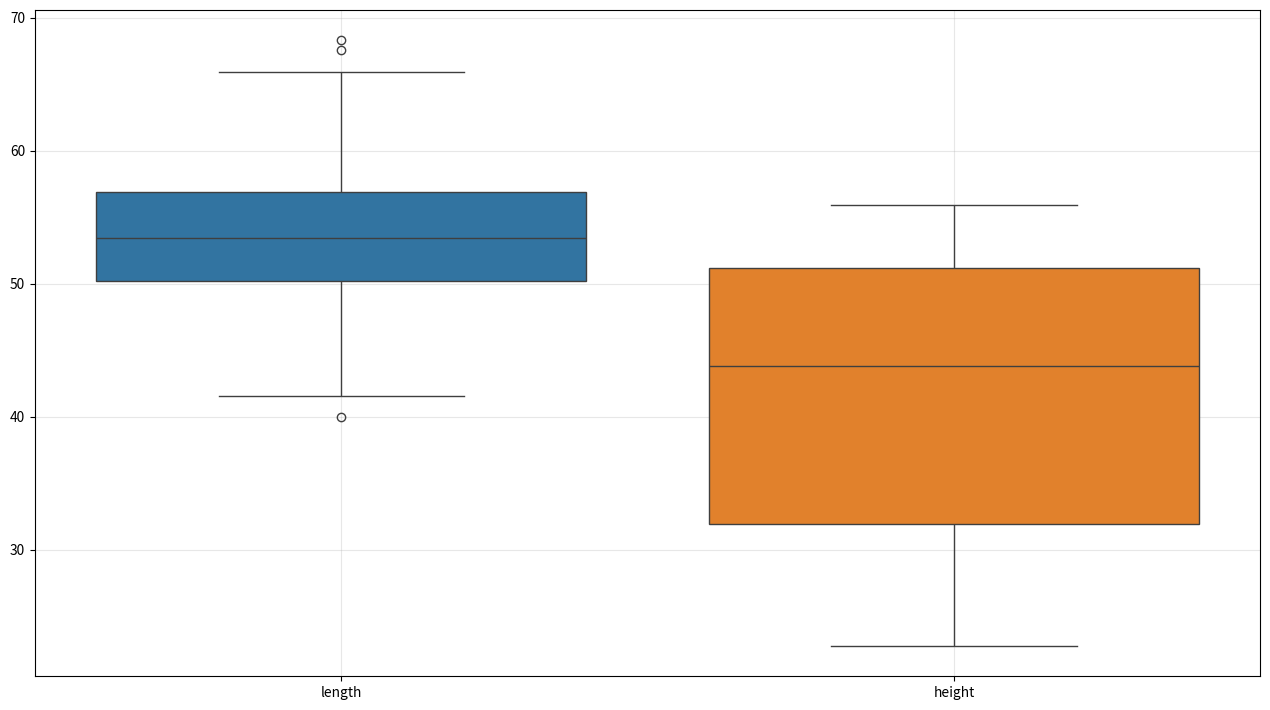

In [57]:
my_dpi = 100
figsize = (1280/my_dpi, 720/my_dpi)
fig, ax = plt.subplots(1, 1, figsize = figsize, dpi = my_dpi)

sb.boxplot(data = origin, orient = 'v')

ax.grid(True, alpha = 0.3)

plt.tight_layout()
plt.show()
plt.close()

### 2. 명목형 변수 확인
#### 명목형 변수 품질 확인 함수 정의

In [58]:
def category_describe(data, columns = None):
    num_columns = data.select_dtypes(include=np.number).columns

    if not columns:
        # 명목형(범주형) 컬럼 선택: object, category, bool 타입
        columns = data.select_dtypes(include = ['object', 'category','bool']).columns # type: ignore

    result =[]
    summary =[]
    for f in columns:
        # 숫자형 컬럼은 건너뜀
        if f in num_columns:
            continue

        # 각 범주값의 빈도수 계산 (NaN 포함)
        value_counts = data[f].value_counts(dropna = False)

        # 범주별 빈도/비율 정보 추가 (category_table 기능)
        for category, count in value_counts.items():
            rate = (count / len(data)) * 100
            result.append({
                '변수':f,
                '범주': category,
                '빈도': count,
                '비율(%)': round(rate, 2)
            })

        if len(value_counts) == 0:
            continue

        # 최다/최소 범주 정보 추가(category_decribe 기능)
        max_category = value_counts.index[0]
        max_count = value_counts.iloc[0]
        max_rate = (max_count / len(data)) * 100
        min_category = value_counts.index[-1]
        min_count = value_counts.iloc[-1]
        min_rate = (min_count / len(data)) * 100
        summary.append({
                '변수':f,
                '최다_범주': max_category,
                '최다_비율(%)': round(max_rate, 2),
                '최소_비율(%)': round(min_rate, 2),
                '최소_범주': min_category
        })

    return DataFrame(result), DataFrame(summary).set_index('변수')

#### 명목형 품질 확인

In [59]:
a, b = category_describe(df)
display(a)
display(b)

,변수,범주,빈도,비율(%)
0,dog,d,100,50.000
1,dog,j,100,50.000


,최다_범주,최다_비율(%),최소_비율(%),최소_범주
변수,,,,
dog,d,50.000,50.000,j


#### 명목형 분포 시각화

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

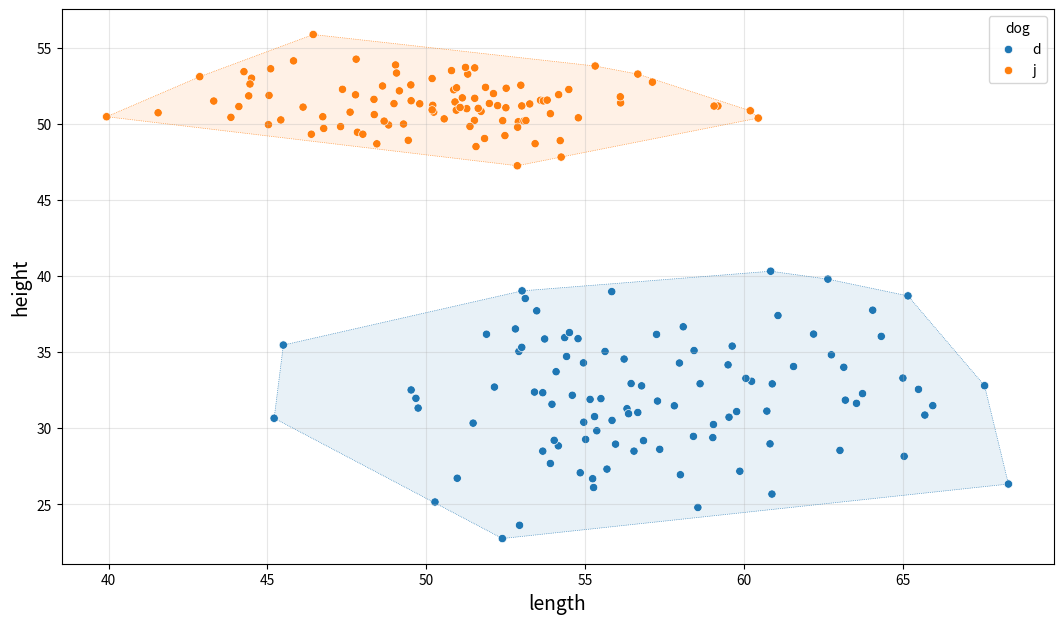

In [60]:
vdf = df.copy()
hue_field = 'dog'
x_field = 'length'
y_field = 'height'
my_dpi = 100

figsize = (1280/my_dpi, 720/my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi = my_dpi)

# 군집별, 값의 종류별로 반복
for c in vdf[hue_field].unique():
    # 값의 종류별로 데이터프레임을 나눔
    df_c = vdf.loc[vdf[hue_field] == c, [x_field, y_field]]

    try:
        hull = ConvexHull(df_c) # 마지막 좌표 이후에 첫 번째 좌표를 연결
        points = np.append(hull.vertices, hull.vertices[0]) # 시작점과 끝점을 연결
        ax.plot(df_c.iloc[points, 0], df_c.iloc[points, 1], linewidth = 0.5, linestyle = ':')
        ax.fill(df_c.iloc[points, 0], df_c.iloc[points, 1], alpha = 0.1)
    except:
        pass

sb.scatterplot(data=vdf, x=x_field, y=y_field, hue=hue_field)
ax.grid(True, alpha=0.3)
plt.tight_layout
    

#### 인사이트
- 닥스훈트와 진돗개의 품종에 따라 신체적인 특징이 구분됨을 확인할 수 있다

### 3. 데이터 전처리
#### 1. 종속변수 라벨링


In [61]:
df2 = df.copy()
df2['dog'] = df2['dog'].map({'d': 0, 'j': 1})
display(df2.head())
df2.info()

,dog,length,height
0,0,55.010,29.270
1,0,59.010,29.390
2,0,56.530,28.500
3,0,53.660,28.500
4,0,49.670,31.970


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   dog     200 non-null    category
 1   length  200 non-null    float64 
 2   height  200 non-null    float64 
dtypes: category(1), float64(2)
memory usage: 3.6 KB


#### 2. 훈련, 검증 데이터 분리

In [62]:
df3 = df2

yname = 'dog'
x = df3.drop(columns = [yname])
y = df3[yname]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.25, random_state = 52
)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((150, 2), (50, 2), (150,), (50,))

### 4. 로지스틱 회귀모형 적합

In [63]:
%%time

pipe = Pipeline([('VIF_Selector', VIFSelector()), ('scaler', StandardScaler()), ('model', LogisticRegression(random_state = 52))])

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs'],
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__max_iter': [100, 300, 500],
    'model__class_weight': [None, 'balanced']
    
    # poly 커널 확장용 (필요시 사용, 학습속도가 매우 느려짐)
    # 'model__kernel':['poly'],
    # 'model__degree':[2, 3, 4],
    # 'model__coef0':[0.0, 0.5, 1.0]
    }

# 그리드 서치 객체 생성
gs = GridSearchCV(estimator = pipe, param_grid = param_grid, cv=5, scoring ='roc_auc', n_jobs = -1)

gs.fit(x_train, y_train)
estimator = gs.best_estimator_
estimator

CPU times: total: 500 ms
Wall time: 18.9 s


Pipeline(steps=[('VIF_Selector', VIFSelector()), ('scaler', StandardScaler()),
                ('model', LogisticRegression(C=0.01, random_state=52))])

### 2. 검증데이터를 통한 추정값 생성

In [64]:
y_pred = estimator.predict(x_test)
y_pred

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1], dtype=int64)

### 3, 결과 시각화

In [65]:
df4 = x_test.copy()
df4['y_test'] = y_test
df4['y_pred'] = y_pred
df4.head()

,length,height,y_test,y_pred
119,54.480,52.260,1,1
62,59.030,30.250,0,0
132,55.310,53.800,1,1
114,42.870,53.100,1,1
104,56.110,51.380,1,1


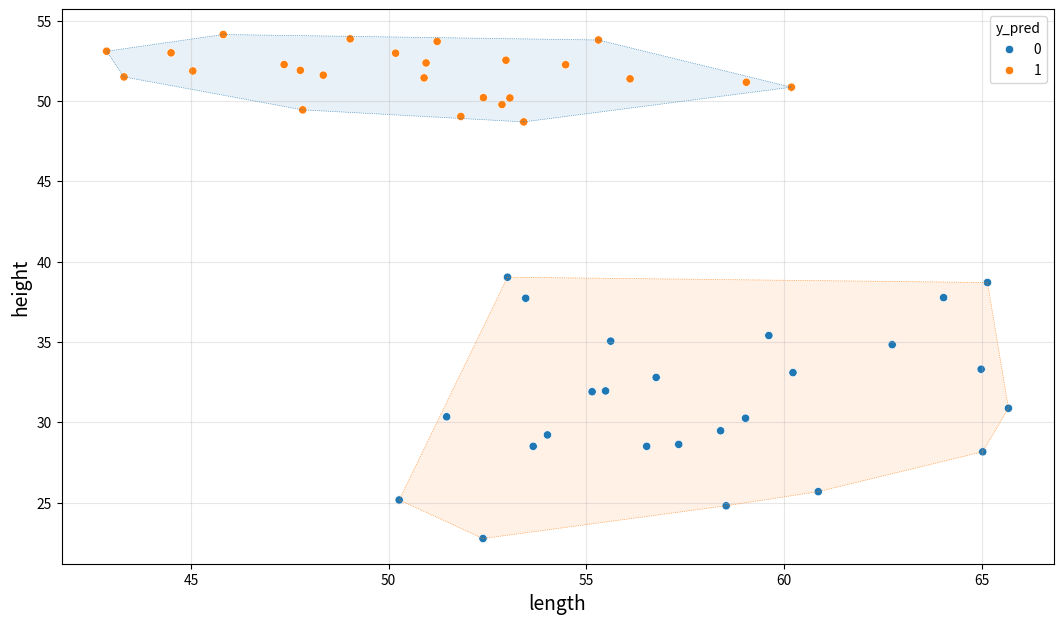

In [66]:
vdf = df4.copy()
hue_field = 'y_pred'
x_field = 'length'
y_field = 'height'

figsize = (1280/my_dpi, 720/my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi = my_dpi)

# 군집별, 값의 종류별로 반복
for c in vdf[hue_field].unique():
    # 값의 종류별로 데이터프레임을 나눔
    df_c = vdf.loc[vdf[hue_field] == c, [x_field, y_field]]

    try:
        hull = ConvexHull(df_c) # 마지막 좌표 이후에 첫 번째 좌표를 연결
        points = np.append(hull.vertices, hull.vertices[0]) # 시작점과 끝점을 연결
        ax.plot(df_c.iloc[points, 0], df_c.iloc[points, 1], linewidth = 0.5, linestyle = ':')
        ax.fill(df_c.iloc[points, 0], df_c.iloc[points, 1], alpha = 0.1)
    except:
        pass

sb.scatterplot(data=vdf, x=x_field, y=y_field, hue=hue_field)
ax.grid(True, alpha=0.3)
plt.tight_layout
plt.show()
plt.close()

## 5. 새로운 정보 통한 예측 수행

In [67]:
input_df = DataFrame({
    'length': [47, 39, 52],
    'height': [23, 42, 49]
})

input_df['y_pred'] = estimator.predict(input_df)
input_df

,length,height,y_pred
0,47,23,0
1,39,42,1
2,52,49,1


# 로지스틱-성능평가(2)

In [68]:
origin = load_data('pima_indians_diabetes')
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print(origin.info())
origin.head()

이 데이터 세트는 원래 미국 국립 당뇨병·소화기·신장질환 연구소(National Institute of Diabetes and Digestive and Kidney Diseases)에서 제공한 것입니다. 이 데이터 세트의 목적은 데이터 세트에 포함된 특정 진단 측정값을 기반으로 환자의 당뇨병 여부를 진단적으로 예측하는 것입니다. 더 큰 데이터베이스에서 이러한 사례를 선택하는 데에는 몇 가지 제약 조건이 적용되었습니다. 특히, 여기에 포함된 모든 환자는 21세 이상의 피마 인디언 혈통을 가진 여성입니다. (출처: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

field                     type    description
------------------------  ------  --------------------------------
Pregnancies               연속형  임신횟수
Glucose                   연속형  포도당 부하 검사 수치
BloodPressure             연속형  혈압
SkinThickness             연속형  팔 삼두근 뒤쪽의 피하지방 측정값
Insulin                   연속형  혈청 인슐린
BMI                       연속형  체질량 지수
DiabetesPedigreeFunction  연속형  당뇨 내력 가중치 값
Age                       연속형  나이
Outcome                   명목형  당뇨여부(0 또는 1)

데이터셋 크기: (768, 9)
열 개수: 9
행 개수: 768
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column              

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


## 1. 데이터 품질 확인
### 1. 명목형 타입 변환

In [69]:
df1 = origin.astype({'Outcome':'category'})
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Pregnancies               768 non-null    int64   
 1   Glucose                   768 non-null    int64   
 2   BloodPressure             768 non-null    int64   
 3   SkinThickness             768 non-null    int64   
 4   Insulin                   768 non-null    int64   
 5   BMI                       768 non-null    float64 
 6   DiabetesPedigreeFunction  768 non-null    float64 
 7   Age                       768 non-null    int64   
 8   Outcome                   768 non-null    category
dtypes: category(1), float64(2), int64(6)
memory usage: 49.0 KB


In [70]:
def hs_describe(data, columns = None):
    num_columns = list(data.select_dtypes(include=np.number).columns)

    if not columns:
        columns = num_columns

    # 기술통계량 구하기
    desc = data[columns].describe().T

    # 각 컬럼별 결측치 수(na_count) 추가
    na_counts = data[columns].isnull().sum()
    desc.insert(1, 'na_count', na_counts)

    # 결측치 비율(na_rate)추가
    desc.insert(2, 'na_rate', (na_counts / len(data))*100)

    # 추가 통계량 계산
    additional_stats = []
    for f in columns:
        # 숫자 타입이 아니라면 건너뜀
        if f not in num_columns:
            continue

        # 사분위수
        q1 = data[f].quantile(q=0.25)
        q3 = data[f].quantile(q=0.75)

        # 이상치 경계(Turkey's fences)
        iqr = q3 - q1
        down = q1 - 1.5 * iqr
        up = q3 + 1.5 * iqr

        # 왜도
        skew = data[f].skew()

        # 이상치 개수 및 비율
        outlier_count = ((data[f]<down) | (data[f]>up)).sum()
        outlier_rate = (outlier_count / len(data)) * 100

        # 분포 특성 판정 (왜도 기준)
        abs_skew = abs(skew)
        if abs_skew < 0.5:
            dist = '거의 대칭'
        elif abs_skew < 1.0:
            if skew > 0:
                dist = '약한 우측 꼬리'
            else:
                dist = '약한 좌측 꼬리'
        elif abs_skew < 2.0:
            if skew > 0:
                dist = '중간 우측 꼬리'
            else:
                dist = '중간 좌측 꼬리'
        elif abs_skew < 0:
            if skew > 0:
                dist = '극단 우측 꼬리'
            else:
                dist = '극단 좌측 꼬리'

        # 로그변환 필요성 판정
        if abs_skew < 0.5:
            log_need = '낮음'
        elif abs_skew < 1.0:
            log_need = '중간'
        else:
            log_need = '낮음'
        
        additional_stats.append({
            'field':f,
            'iqr':iqr,
            'up':up,
            'down':down,
            'outlier_count':outlier_count,
            'outlier_rate':outlier_rate,
            'skew':skew,
            'dist':dist,
            'log_need':log_need
        })

    additional_df = DataFrame(additional_stats).set_index('field')

    # 결과 병합
    result = concat([desc, additional_df], axis = 1)

    return result


In [71]:
def hs_category_describe(data, columns = None):
    num_columns = data.select_dtypes(include=np.number).columns

    if not columns:
        # 명목형(범주형) 컬럼 선택: object, category, bool 타입
        columns = data.select_dtypes(include = ['object', 'category','bool']).columns # type: ignore

    result =[]
    summary =[]
    for f in columns:
        # 숫자형 컬럼은 건너뜀
        if f in num_columns:
            continue

        # 각 범주값의 빈도수 계산 (NaN 포함)
        value_counts = data[f].value_counts(dropna = False)

        # 범주별 빈도/비율 정보 추가 (category_table 기능)
        for category, count in value_counts.items():
            rate = (count / len(data)) * 100
            result.append({
                '변수':f,
                '범주': category,
                '빈도': count,
                '비율(%)': round(rate, 2)
            })

        if len(value_counts) == 0:
            continue

        # 최다/최소 범주 정보 추가(category_decribe 기능)
        max_category = value_counts.index[0]
        max_count = value_counts.iloc[0]
        max_rate = (max_count / len(data)) * 100
        min_category = value_counts.index[-1]
        min_count = value_counts.iloc[-1]
        min_rate = (min_count / len(data)) * 100
        summary.append({
                '변수':f,
                '최다_범주': max_category,
                '최다_비율(%)': round(max_rate, 2),
                '최소_비율(%)': round(min_rate, 2),
                '최소_범주': min_category
        })

    return DataFrame(result), DataFrame(summary).set_index('변수')

### 2. 연속형 데이터의 품질 확인

In [72]:
hs_describe(df1)

,count,na_count,na_rate,mean,std,min,25%,50%,75%,max,iqr,up,down,outlier_count,outlier_rate,skew,dist,log_need
Pregnancies,768.000,0,0.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000,5.000,13.500,-6.500,4,0.521,0.902,약한 우측 꼬리,중간
Glucose,768.000,0,0.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000,41.250,202.125,37.125,5,0.651,0.174,거의 대칭,낮음
BloodPressure,768.000,0,0.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000,18.000,107.000,35.000,45,5.859,-1.844,중간 좌측 꼬리,낮음
SkinThickness,768.000,0,0.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000,32.000,80.000,-48.000,1,0.130,0.109,거의 대칭,낮음
Insulin,768.000,0,0.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000,127.250,318.125,-190.875,34,4.427,2.272,거의 대칭,낮음
BMI,768.000,0,0.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100,9.300,50.550,13.350,19,2.474,-0.429,거의 대칭,낮음
DiabetesPedigreeFunction,768.000,0,0.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420,0.382,1.200,-0.330,29,3.776,1.920,중간 우측 꼬리,낮음
Age,768.000,0,0.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000,17.000,66.500,-1.500,9,1.172,1.130,중간 우측 꼬리,낮음


#### 인사이트
- 결측값 처리(우선순위:높음)
    - 문제: 공식 결측값은 없으나, 0값이 다수 존재(생리학적으로 불가능한 값)
    - 영향 변수:
        - Glucose:최소값 0 -> 혈당이 0일 수 없음
        - BloodPressure: 최소값 0 -> 혈압이 0일 수 없음
        - BMI: 최소값 0 -> BMI가 0일 수 없음
        - SkinThickness: Q1이 0 -> 다수의 0값 존재
        - Insulin: Q1이 0 -> 다수의 0값 존재

    - 처리 방법:
        - 0값을 NaN으로 변환 후 처리
        - 중앙값/ 평균값 대체 또는 KNN Imputer 활용
        - 삭제할 경우 데이터 손실 고려 필요

- 이상치 처리 - 왜도 조정 및 변환(우선순위:중간)
    - 로그변환 필요성 높음:
        - BloodPressure: 중간 좌측 꼬리(skew: -1.844)
        - Insulin: 극단 우측 꼬리(skew: 2.272)
        - DiabetesPedigreeFunction: 중간 우측 꼬리(skew:1.920)
        - Insulin: 극단 우측 꼬리(skew:1.130)
    - 처리 방법:
        - 로그변환

- 정규화/표준화(우선순위:낮음)
    - 필요성: 변수별 스케일 차이 존재(Age:21-81, Insulin: 0-846)
    - 처리 방법:
        - StandardScaler 또는 MinMaxScler 적용
        - 로지스틱 회귀의 경우 StandardScaler 권장
        

### 3. 명목형 데이터의 품질 확인

In [73]:
a, b = hs_category_describe(df1)
display(a)
display(b)

,변수,범주,빈도,비율(%)
0,Outcome,0,500,65.100
1,Outcome,1,268,34.900


,최다_범주,최다_비율(%),최소_비율(%),최소_범주
변수,,,,
Outcome,0,65.100,34.900,1


## 2. 데이터 전처리
### 1. 결측치 정제

In [74]:
# 0값을 검사할 피처명 리스트
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

df2 = df1. copy()
df2[zero_features] = df2[zero_features].replace(0, np.nan)
df2.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.000,72.000,35.000,NaN,33.600,0.627,50,1
1,1,85.000,66.000,29.000,NaN,26.600,0.351,31,0
2,8,183.000,64.000,NaN,NaN,23.300,0.672,32,1
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1


In [75]:
imr = SimpleImputer(missing_values = np.nan, strategy = 'median')
df_imr = imr.fit_transform(df2.values)

df3 = DataFrame(df_imr,
                index = df2.index,       # 원본 인덱스
                columns = df2.columns
                )
# 결측치 처리 과정에서 범주형 데이터 타입이 변경되었으므로 복원
df3 = df3.astype({'Outcome':'category'})

# 데이터 품질 재검사
desc = hs_describe(df3)
desc

,count,na_count,na_rate,mean,std,min,25%,50%,75%,max,iqr,up,down,outlier_count,outlier_rate,skew,dist,log_need
Pregnancies,768.000,0,0.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000,5.000,13.500,-6.500,4,0.521,0.902,약한 우측 꼬리,중간
Glucose,768.000,0,0.000,121.656,30.438,44.000,99.750,117.000,140.250,199.000,40.500,201.000,39.000,0,0.000,0.536,약한 우측 꼬리,중간
BloodPressure,768.000,0,0.000,72.387,12.097,24.000,64.000,72.000,80.000,122.000,16.000,104.000,40.000,14,1.823,0.142,거의 대칭,낮음
SkinThickness,768.000,0,0.000,29.108,8.791,7.000,25.000,29.000,32.000,99.000,7.000,42.500,14.500,87,11.328,0.838,약한 우측 꼬리,중간
Insulin,768.000,0,0.000,140.672,86.383,14.000,121.500,125.000,127.250,846.000,5.750,135.875,112.875,346,45.052,3.380,약한 우측 꼬리,낮음
BMI,768.000,0,0.000,32.455,6.875,18.200,27.500,32.300,36.600,67.100,9.100,50.250,13.850,8,1.042,0.599,약한 우측 꼬리,중간
DiabetesPedigreeFunction,768.000,0,0.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420,0.382,1.200,-0.330,29,3.776,1.920,중간 우측 꼬리,낮음
Age,768.000,0,0.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000,17.000,66.500,-1.500,9,1.172,1.130,중간 우측 꼬리,낮음


### 2. 이상치 처리(로그변환)

In [76]:
log_fields = desc[desc['log_need']!= '낮음'].index.tolist()

df4 = df3.copy()

for f in log_fields:
    df4[f] = np.log1p(df4[f])     # log(1+x) 적용
hs_describe(df4)

,count,na_count,na_rate,mean,std,min,25%,50%,75%,max,iqr,up,down,outlier_count,outlier_rate,skew,dist,log_need
Pregnancies,768.000,0,0.000,1.311,0.770,0.000,0.693,1.386,1.946,2.890,1.253,3.825,-1.186,0,0.000,-0.243,거의 대칭,낮음
Glucose,768.000,0,0.000,4.779,0.248,3.807,4.613,4.771,4.951,5.298,0.338,5.457,4.106,4,0.521,-0.058,거의 대칭,낮음
BloodPressure,768.000,0,0.000,72.387,12.097,24.000,64.000,72.000,80.000,122.000,16.000,104.000,40.000,14,1.823,0.142,거의 대칭,낮음
SkinThickness,768.000,0,0.000,3.359,0.314,2.079,3.258,3.401,3.497,4.605,0.238,3.854,2.900,96,12.500,-0.859,약한 좌측 꼬리,중간
Insulin,768.000,0,0.000,140.672,86.383,14.000,121.500,125.000,127.250,846.000,5.750,135.875,112.875,346,45.052,3.380,약한 좌측 꼬리,낮음
BMI,768.000,0,0.000,3.489,0.204,2.955,3.350,3.506,3.627,4.221,0.277,4.043,2.934,3,0.391,-0.038,거의 대칭,낮음
DiabetesPedigreeFunction,768.000,0,0.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420,0.382,1.200,-0.330,29,3.776,1.920,중간 우측 꼬리,낮음
Age,768.000,0,0.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000,17.000,66.500,-1.500,9,1.172,1.130,중간 우측 꼬리,낮음


#### 4. 훈련, 검증 데이터 분리

In [77]:
df = df4

# 중요 point: 종속변수를 정수형으로 변환해야 한다.
df['Outcome'] = df['Outcome'].astype('int')

yname = 'Outcome'
x = df.drop(columns = [yname])
y = df[yname]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.2, random_state = 52
)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

## 3. 로지스틱 모형 적합

In [78]:
%%time

pipe = Pipeline([('VIF_Selector', VIFSelector()), ('scaler', StandardScaler()), ('model', LogisticRegression(random_state = 52))])

# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'model__penalty': ['l2'],
    'model__solver': ['lbfgs'],
    'model__C': [0.01, 0.1, 1, 10, 100],
    
    
    # poly 커널 확장용 (필요시 사용, 학습속도가 매우 느려짐)
    # 'model__kernel':['poly'],
    # 'model__degree':[2, 3, 4],
    # 'model__coef0':[0.0, 0.5, 1.0]
    }

# 그리드 서치 객체 생성
gs = GridSearchCV(estimator = pipe, param_grid = param_grid, cv=5, scoring ='roc_auc', n_jobs = -1)

gs.fit(x_train, y_train)
estimator = gs.best_estimator_
estimator

CPU times: total: 62.5 ms
Wall time: 76.1 ms


Pipeline(steps=[('VIF_Selector', VIFSelector()), ('scaler', StandardScaler()),
                ('model', LogisticRegression(C=0.1, random_state=52))])

## 4. 성능평가 지표
### 1. 의사결정계수

In [79]:
r2 = estimator.score(x_test, y_test)
r2

0.7857142857142857

### 2. 예측값
#### 1. 위, 양성 확률
- 0으로 분류될 확률과 1로 분류될 확률을 의미

In [80]:
y_pred_proba = estimator.predict_proba(x_test)
y_pred_proba

array([[0.29954307, 0.70045693],
       [0.96163477, 0.03836523],
       [0.5623043 , 0.4376957 ],
       [0.50300157, 0.49699843],
       [0.98338588, 0.01661412],
       [0.54326345, 0.45673655],
       [0.25457084, 0.74542916],
       [0.9393942 , 0.0606058 ],
       [0.92836974, 0.07163026],
       [0.51144932, 0.48855068],
       [0.86203364, 0.13796636],
       [0.34703348, 0.65296652],
       [0.72385965, 0.27614035],
       [0.49036398, 0.50963602],
       [0.76548849, 0.23451151],
       [0.38397687, 0.61602313],
       [0.96992713, 0.03007287],
       [0.15718376, 0.84281624],
       [0.20453847, 0.79546153],
       [0.60697704, 0.39302296],
       [0.2147457 , 0.7852543 ],
       [0.72190821, 0.27809179],
       [0.80387076, 0.19612924],
       [0.68201632, 0.31798368],
       [0.60426222, 0.39573778],
       [0.62577381, 0.37422619],
       [0.67776284, 0.32223716],
       [0.68666166, 0.31333834],
       [0.165641  , 0.834359  ],
       [0.16454805, 0.83545195],
       [0.

#### 2. 보통은 1로 분류될 확률만 선택적으로 추출함
- roc-curbe 산정에 사용

In [81]:
y_pred_proba_1 = estimator.predict_proba(x_test)[:, 1]
y_pred_proba_1[:5]

array([0.70045693, 0.03836523, 0.4376957 , 0.49699843, 0.01661412])

#### 3. 예측값 
- 0, 1중에서 예측 결과를 의미

In [82]:
y_pred = estimator.predict(x_test)
y_pred

array([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

### 3. 혼동행렬

In [83]:
cm = confusion_matrix(y_test, y_pred)

cmdf = DataFrame(cm, index = ['Actual 0 (TN/FP)', 'Actual 1 (FN/TP)'], columns =['Predicted (Negative)', 'Predicted (Positive)'])
cmdf

,Predicted (Negative),Predicted (Positive)
Actual 0 (TN/FP),87,13
Actual 1 (FN/TP),20,34


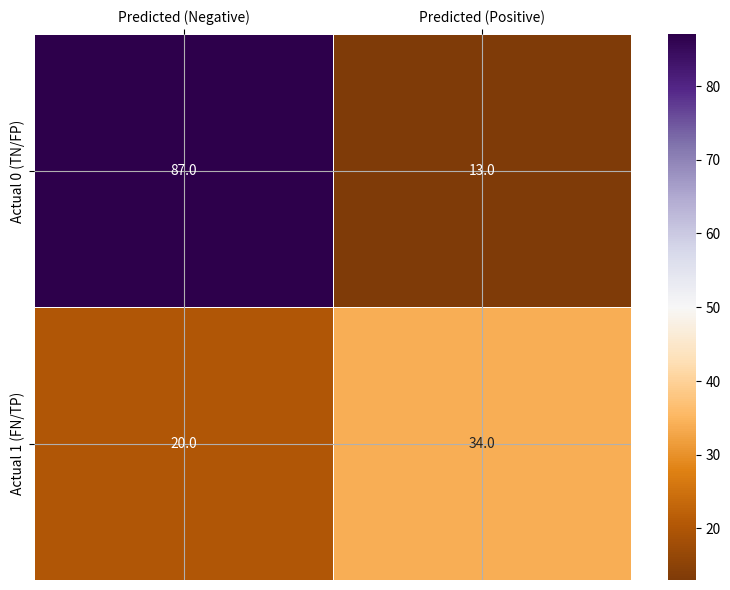

In [84]:
width_px = 800
height_px = 600
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# bar 그리기
sb.heatmap(data=cmdf,
           annot = True,
           fmt = '0.1f' ,           
           linewidth = 0.5,
           cmap = 'PuOr')        

ax.grid(True)
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.tick_top()      # x축의 변수 이름을 상단으로 이동
# 출력
plt.tight_layout()
plt.show()
plt.close()

### 4. 정확도(Accuracy)
- 전체(FP + FN + TP + TN) 중 (TP + TN) 비율


In [85]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7857142857142857

### 5. 정밀도

In [86]:
precision = precision_score(y_test, y_pred)
precision

0.723404255319149

### 6. 재현율

In [87]:
tpr = recall_score(y_test, y_pred)
tpr

0.6296296296296297

### 7. F1 Score

In [88]:
f1 = f1_score(y_test, y_pred)
f1

0.6732673267326733

### 8. ROC Curve

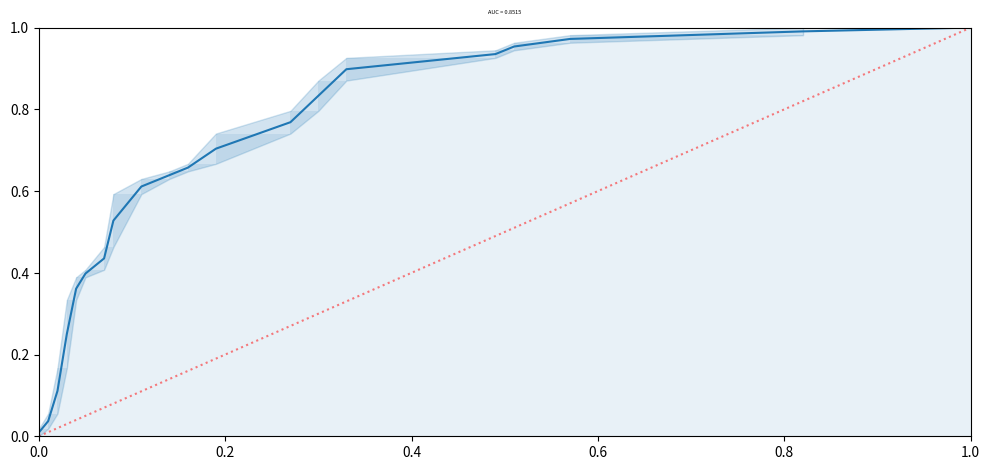

In [91]:
auc = roc_auc_score(y_test, y_pred_proba_1)

roc_fpr, roc_tpr, thresholds = roc_curve(y_test, y_pred_proba_1)

width_px = 1000
height_px = 480
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 그래프 그리기, seaborn 사용
sb.lineplot(x = roc_fpr, y = roc_tpr)

sb.lineplot(x= [0, 1], y = [0, 1],
           color = 'red', linestyle = ':', alpha = 0.5
           )
plt.fill_between(x=roc_fpr, y1 = roc_tpr, alpha = 0.1)
# 그래프 꾸미기
ax.grid(True) # 배경 격자 표시/숨김
ax.set_title(f'AUC = {auc:.4f}', pad = 10, fontsize = 4)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
# 출력
plt.grid()
plt.tight_layout()
plt.show()
plt.close()


### 9. 위양성율, 거짓 양성 비율(Fallout, FPR)
- 다항로지스틱에서는 사용할 수 없음

In [92]:
fpr = FP / (TN + FP)
fpr

NameError: name 'FP' is not defined

## 5. ROC Curve 해석 방법

- True Positive Rate 와 False Positive Rate

- Recall은 True Positive Rate의 다른 이름

- TPR로 부르는 이유는 FRP과 함께 쓸 경우 이해하기 훨씬 쉽기 때문

- TPR은 Positive 예측이 성공한 비율을 설명하는 값으로 높을수록 좋음

- FPR은 Positive 예측이 실패한 비율을 설명하는 값으로 낮을수록 좋음

- THreshold가 100%에서부터 시작해 0%까지 도달하는 과정에서 그래프가 그려짐

- 1단계

- 선정기준(Threshold)가 100%인 상태부터 시작함(엄격함)
- 이 경우, 어떠한 데이터도 Positive로 분류되지 않고 모든 데이터가 Negative로 분류됨
- 그러므로 TPR과 FPR 모두 0%임

- 2단계
- 분류 기준이 다소 완화되어 Positive로 분류된 데이터가 1건 생김

- 3단계
- 분류 기준이 더 완화되어 Positive로 분류된 데이터가 3건 생김

- 4단계
- 기준이 낮아짐에 따라 되는 Positive로 분류되는 사례가 증가함

- 5단계
- 분류 기준이 더욱 완화되어 잘못 판단하는 사례가 생김.
- 그에 따라 실제로는 Negative 였던 FP가 발생함

- 6단계
- 분류 기준이 더더욱 완화되어 실제로 Positive인 TP와 실제로는 Negative였던 FP 모두 증가함

- 7단계
- 분류 기준이 더더욱 완화되어 실제로 Positive인 TP는 100% 분류해 내지만 실제로는 Negative 였던 항목을 True로 분류하는 사례도 높아짐 FP 모두 증가함

- 8단계
- 기준이 왼편 끝으로 이동함에 따라 모든 데이터가 Positive로 분류되고 그 결과 TPR, FPR 모두 1에 도달함

## 6. 과적합 판정
### 1. 과적합 판정 표 구성
#### 1. 문제 유형 판별

In [ ]:
is_classification = hasattr(estimator, '_estimator_type') and estimator._estimator_type =='classifier'
is_classification

True

#### 2. 클래스 이름

In [ ]:
if hasattr(estimator, 'named_steps'):
    classname = estimator.named_steps['model'].__class__.__name__
else:
    classname = estimator.__class__.__name__

classname

'LogisticRegression'

#### 3. 평가 기준, 교차검증 수, 학습곡선 데이터 비율, jobs

In [ ]:
scoring = 'roc_auc'
cv = 5
train_sizes = np.linspace(0.1, 1.0, 10)
n_jobs = -1

scoring, cv, train_sizes

('roc_auc', 5, array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

#### 4. learning curve 계산

In [ ]:
train_sizes, train_scores, cv_scores = learning_curve(
    # type: ignore
    estimator = estimator,
    X=x,
    y=y,
    train_sizes = train_sizes,
    cv = cv,
    scoring = scoring,
    n_jobs = n_jobs,
    shuffle = False,
    random_state = 52
)

train_sizes, train_scores, cv_scores

(array([ 61, 122, 184, 245, 307, 368, 429, 491, 552, 614]),
 array([[0.91208791, 0.79847495, 0.79847495, 0.79847495, 0.79847495],
        [0.865     , 0.85021645, 0.85021645, 0.85021645, 0.85021645],
        [0.81927418, 0.81721083, 0.83723958, 0.83723958, 0.83723958],
        [0.84020619, 0.84250488, 0.83859649, 0.83859649, 0.83859649],
        [0.83795432, 0.8411979 , 0.82165457, 0.81710161, 0.81710161],
        [0.83804191, 0.83724204, 0.81817309, 0.81844596, 0.81844596],
        [0.84672167, 0.84693878, 0.83188595, 0.82762288, 0.82832874],
        [0.85664504, 0.85725672, 0.84385542, 0.82878687, 0.82316899],
        [0.85093358, 0.85013191, 0.83755302, 0.82692643, 0.83279466],
        [0.85218458, 0.85272196, 0.84125   , 0.83092615, 0.84600467]]),
 array([[0.78277778, 0.77222222, 0.8387037 , 0.84433962, 0.81792453],
        [0.78148148, 0.76944444, 0.83018519, 0.85830189, 0.81849057],
        [0.7912963 , 0.78981481, 0.83462963, 0.87924528, 0.83132075],
        [0.79944444, 0.78888

#### 5. 과적합 판정

In [ ]:
# 분류는 스코어를 그대로 사용
train_metric = train_scores # AUC
cv_metric = cv_scores # Accuracy

train_mean = train_metric.mean(axis = 1)
cv_mean = cv_metric.mean(axis = 1)
cv_std = cv_metric.std(axis = 1)

final_train = train_mean[-1]
final_cv = cv_mean[-1]
final_std = cv_std[-1]

# 분류용 비율 정의 (차이기반)
gap_ratio = final_train - final_cv
var_ratio = final_std

# 분류 판정 로직(객관적 기준)
if final_train < 0.6 and final_cv < 0.6:
    status = '과소적합'
elif gap_ratio > 0.1:
    status = '과대적합'
elif gap_ratio <= 0.05:
    status = '과대적합'
elif var_ratio > 0.1:
    status = '데이터 부족'
else:
    status = '판단유보'

metric_name = scoring.upper()

result_df = DataFrame(
    {
        f'Train {metric_name}': [final_train],
        f'CV {metric_name}평균': [final_cv],
        f'CV {metric_name}표준편차':[final_std],
        f'Train/CV 비율':[gap_ratio],
        f'CV 변동성 비율':[var_ratio],
        '판정 결과': [status]
    },
    index = [classname]
)

result_df

,Train ROC_AUC,CV ROC_AUC평균,CV ROC_AUC표준편차,Train/CV 비율,CV 변동성 비율,판정 결과
LogisticRegression,0.845,0.837,0.031,0.008,0.031,과대적합


### 2. 학습곡선

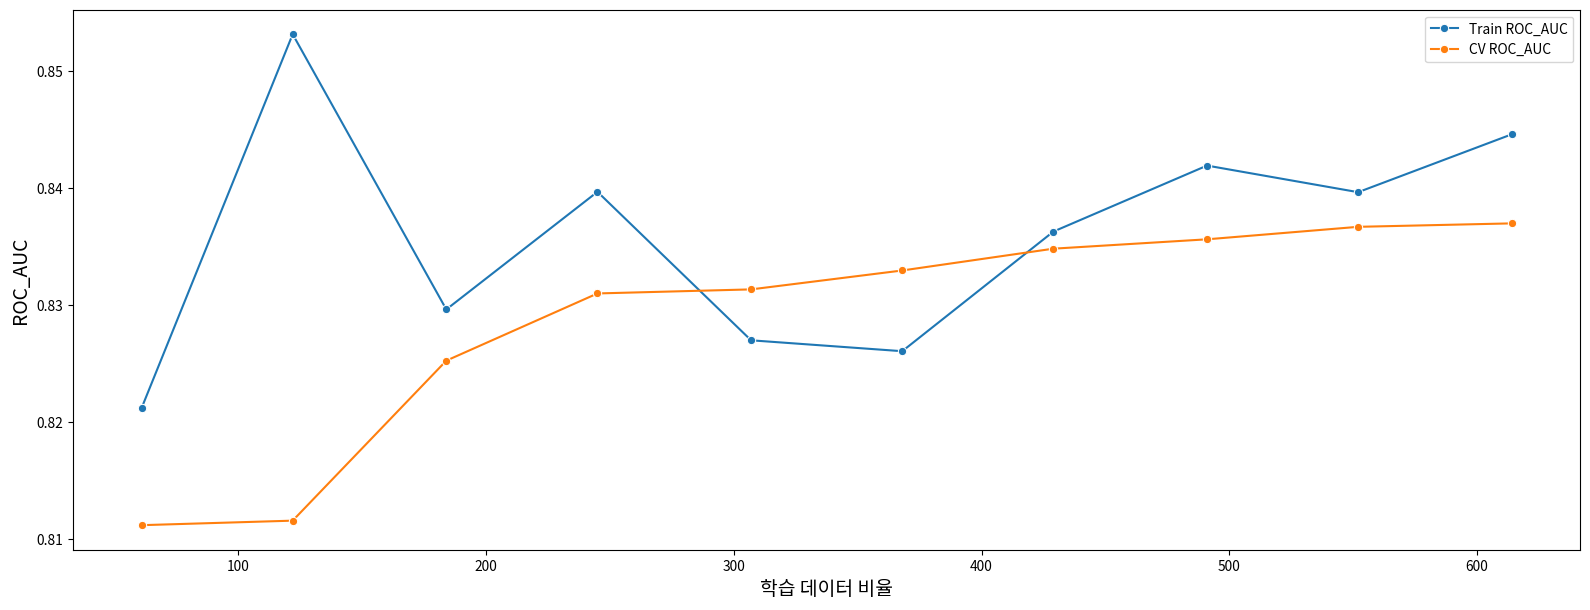

In [ ]:
width_px = 1600
height_px = 620
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 그래프 그리기, seaborn 사용
sb.lineplot(x = train_sizes, y = train_mean, marker = 'o', markeredgecolor = '#ffffff',
            label = f'Train { metric_name}')

sb.lineplot(x = train_sizes, y = cv_mean, marker = 'o', markeredgecolor = '#ffffff',
            label = f'CV { metric_name}')
           
# 그래프 꾸미기
ax.grid(True) # 배경 격자 표시/숨김
ax.set_xlabel('학습 데이터 비율')
ax.set_ylabel(metric_name)
# 출력
plt.grid()
plt.tight_layout()
plt.show()
plt.close()
